## Jugando con autoenconders
Esta notebook tiene el único objetivo de hacer primeras pruebas con autoencoders. Se puede correr en Google Colab.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt


In [2]:
# Definir la arquitectura del autoencoder
class Autoencoder(nn.Module): # La clase Autoencoder hereda de la clase nn.Module, que es una clase base para todos los modelos en PyTorch.
                              # Esto permite que nuestra clase Autoencoder tenga todas las funcionalidades necesarias para ser un modelo de aprendizaje profundo en PyTorch.

    # Dentro del método __init__, definimos las capas del autoencoder.
    def __init__(self, encoding_dim):

        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential( # Encoder
                                      # Toma una imagen de entrada y la comprime en una representación de dimensionalidad más baja llamada encoding_dim

            # Secuencia de capas del codificador:
            nn.Linear(28 * 28, 128), # Capa lineal inicial que toma una imagen de 28x28 píxeles (784 dimensiones después de aplanarla) y la reduce a 128 dimensiones utilizando una función lineal.
            nn.ReLU(), # Luego se aplica una función de activación ReLU para introducir no linealidad en la representación.
            nn.Linear(128, encoding_dim), # Finalmente, otra capa lineal reduce la dimensionalidad a encoding_dim.
        )

        self.decoder = nn.Sequential( # Decoder
                                      # Devuelve la imágen a su tamaño original.

            # Secuencia de capas del decodificador:
            nn.Linear(encoding_dim, 128), # Capa lineal que toma la representación de encoding_dim y la expande a 128 dimensiones.
            nn.ReLU(), # Luego, se aplica una función de activación ReLU.
            nn.Linear(128, 28 * 28), # A continuación, otra capa lineal expande la dimensionalidad a 28x28 píxeles (784 dimensiones).
            nn.Sigmoid(), # Finalmente se aplica una función de activación sigmoide para limitar los valores de salida entre 0 y 1.
        )

    def forward(self, x): # El método forward define cómo se propagan los datos a través del autoencoder.

        encoded = self.encoder(x) # Toma una imagen de entrada x, la pasa por el codificador para obtener la representación comprimida encoded.
        decoded = self.decoder(encoded) # Luego pasa esta representación por el decodificador para obtener la reconstrucción decoded.
        return decoded # La reconstrucción se devuelve como salida.


In [3]:
# Configuración de hiperparámetros
encoding_dim = 32
batch_size = 128 # Cantidad de muestras que se procesan en paralelo antes de que se actualicen los pesos del modelo.
learning_rate = 1e-3
num_epochs = 10


In [4]:
# Cargar los datos de entrenamiento (MNIST)
transform = transforms.Compose([transforms.ToTensor()]) # Convertir las imágenes en tensores de tipo torch.Tensor, lo que permite el procesamiento eficiente de los datos en el modelo.
train_dataset = MNIST(root='./data', train=True, transform=transform, download=True) # Crea una instancia del conjunto de datos MNIST para el entrenamiento.
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # Aquí se crea un objeto DataLoader, que es responsable de cargar los datos en el modelo durante el entrenamiento.
                                                                              # train_dataset es el conjunto de datos que se va a cargar.
                                                                              # batch_size indica el número de ejemplos que se cargarán juntos en cada iteración.
                                                                              # shuffle=True significa que los datos se barajarán aleatoriamente en cada época de entrenamiento para introducir variedad y evitar sesgos en el orden de los ejemplos.

# Solo como comentario, si quiero hacerle varias transformaciones a las imagenes, puedo usar el compose para hacerlas todas seguidas.
# Aca hay unos ejemplos de las cosas que se pueden hacer con transforms:
#transform = transforms.Compose([
#    transforms.Resize((64, 64)),   # Cambiar tamaño a 64x64
#    transforms.ToTensor(),         # Convertir a tensor
#    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalización
#])


# Info util sobre DataLoders y DataSets, para cargar eficientemente el dataset de imagenes
# https://pytorch.org/tutorials/beginner/basics/data_tutorial.html


2.6%

100.0%


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



100.0%

Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw




27.8%

100.0%


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



100.0%

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



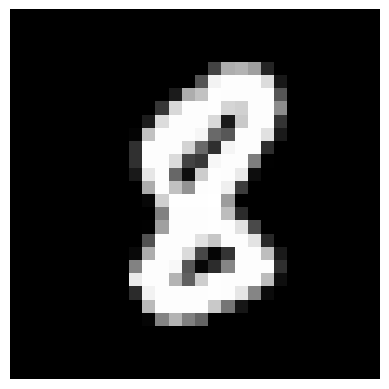

In [5]:
# Visualizamos una de las imágenes del set de entrenamiento solo a modo de ejemplo.
image, label = train_dataset[348]
plt.imshow(image.squeeze(), cmap='gray')
plt.axis('off')
plt.show()


In [6]:
# Crear la instancia del autoencoder
autoencoder = Autoencoder(encoding_dim)


In [7]:
# Definir la función de pérdida y el optimizador
criterion = nn.BCELoss()  # Utilizamos Binary Cross Entropy Loss como loss function ya que las imágenes están normalizadas en el rango [0, 1]
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate) # El optimizador es responsable de ajustar los pesos del modelo con el fin de minimizar la función de pérdida.
                                                                   # Adam es un algoritmo de optimización popular y eficiente que adapta la tasa de aprendizaje de forma dinámica para cada parámetro del modelo.
                                                                   # La tasa de aprendizaje determina qué tan rápido se ajustan los pesos del modelo durante el entrenamiento.


In [8]:
# Entrenamiento del autoencoder
for epoch in range(num_epochs):
    for data in train_loader:
        images, _ = data
        images = images.view(images.size(0), -1)

        # Forward pass
        outputs = autoencoder(images) # Se pasa a las imágenes por el autoencoder, en una pasada forward.
        loss = criterion(outputs, images) # Se calcula la diferencia entre el output y las imágenes originales, según la función de pérdida definida.

        # Backward pass y optimización
        optimizer.zero_grad() # Se restablecen los gradientes acumulados en todos los parámetros del modelo.
                              # Esto es necesario antes de realizar el backward pass, ya que PyTorch acumula los gradientes en cada llamada a loss.backward().
        loss.backward() # Se realiza el backward pass para calcular los gradientes de los parámetros del autoencoder utilizando la función de pérdida.
        optimizer.step() # Finalmente se realiza la optimización de los parámetros del modelo mediante la llamada a optimizer.step(), que actualiza los parámetros en función de los gradientes calculados.

    # Imprimir la pérdida del autoencoder en cada época
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


Epoch [1/10], Loss: 0.1398
Epoch [2/10], Loss: 0.1120
Epoch [3/10], Loss: 0.0998
Epoch [4/10], Loss: 0.1003
Epoch [5/10], Loss: 0.0930
Epoch [6/10], Loss: 0.0886
Epoch [7/10], Loss: 0.0917
Epoch [8/10], Loss: 0.0824
Epoch [9/10], Loss: 0.0866
Epoch [10/10], Loss: 0.0897


In [9]:
# Evaluación del autoencoder
test_dataset = MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

total_loss = 0
with torch.no_grad(): # Esto es para asegurarse de que no se realicen cálculos de gradientes durante la evaluación del autoencoder.
                      # Al entrar en este bloque, se desactiva el cálculo y almacenamiento automático de gradientes para reducir el uso de memoria y acelerar la evaluación.
    for data in test_loader:
        images, _ = data # _ se utiliza para descartar las etiquetas, ya que no son necesarias para la evaluación.
        images = images.view(images.size(0), -1) # Se modifica la forma de las imágenes para que coincida con el formato esperado por el autoencoder.
                                                 # En este caso, las imágenes se aplanan en un tensor unidimensional. images.size(0) se utiliza para obtener el tamaño del lote.

        # Forward pass
        outputs = autoencoder(images) # Se realiza el forward pass del autoencoder con las imágenes de prueba.
                                      # El autoencoder genera las imágenes reconstruidas utilizando el método forward() que definimos previamente en la clase Autoencoder.
        loss = criterion(outputs, images) # Se calcula la pérdida entre las imágenes reconstruidas y las imágenes originales utilizando la función de pérdida (criterion).
                                          # Esto proporciona una medida de cuánto difieren las imágenes reconstruidas de las originales.
        total_loss += loss.item() # La pérdida obtenida en cada iteración se suma a la variable total_loss utilizando loss.item(), que devuelve el valor escalar de la pérdida.
                                  # Al final de la iteración, total_loss contendrá la suma acumulada de las pérdidas de todas las muestras del conjunto de datos de prueba.

average_loss = total_loss / len(test_loader) # Se calcula la pérdida promedio dividiendo la suma acumulada de las pérdidas (total_loss) entre el número de lotes en el conjunto de datos de prueba (len(test_loader)).
                                             # Esto proporciona una medida promedio de la discrepancia entre las imágenes originales y las imágenes reconstruidas por el autoencoder en el conjunto de datos de prueba.
print(f"Average Test Loss: {average_loss:.4f}")


Average Test Loss: 0.0847


(-0.5, 27.5, 27.5, -0.5)

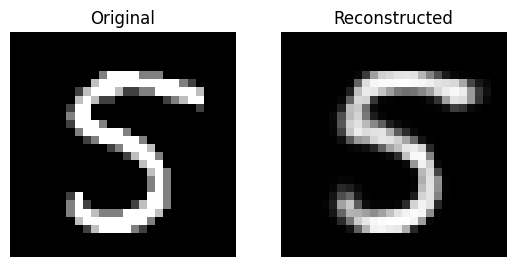

In [10]:
# Ahora aplicamos el autoencoder a un ejemplo particular del dataset de testeo y vemos cómo queda la imagen reconstriuda.

index = 978  # Índice del ejemplo puntual que se desea seleccionar
example = test_dataset[index][0]  # Obtiene la imagen original del ejemplo

example = example.view(1, -1)  # Ajusta la forma de la imagen a un lote de tamaño 1

reconstructed = autoencoder(example)  # Aplica el autoencoder al ejemplo

original = example.view(28, 28)  # Ajusta la forma de la imagen original
reconstructed = reconstructed.view(28, 28)  # Ajusta la forma de la imagen reconstruida

plt.subplot(1, 2, 1)
plt.imshow(original, cmap='gray')
plt.title('Original')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(reconstructed.detach(), cmap='gray')
plt.title('Reconstructed')
plt.axis('off')


Dejo este pedazo de código para tener una idea de cómo habría que cambiar el entrenamiento para que compare la salida del autoencoder con las imágenes limpias en vez de con las imágenes ruidosas del input:

In [ ]:
"""
# Dentro del bucle de entrenamiento
for data in train_loader:
    noisy_images, clean_images = data
    noisy_images = noisy_images.view(noisy_images.size(0), -1)
    clean_images = clean_images.view(clean_images.size(0), -1)

    # Forward pass
    outputs = autoencoder(noisy_images)
    loss = criterion(outputs, clean_images)

    # Backward pass y optimización
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
"""
